In [347]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import time

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Performance
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_score
from sklearn.inspection import permutation_importance

#Resampling
from imblearn.over_sampling import SMOTE

#define gloabal color palette
color = cm.inferno_r(np.linspace(.3, .8, 5))
colorSet2 = sns.color_palette(palette='Set2')
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)

### Business Understanding

European banks are under pressure to increase financial assets due to a lot of competition and worldwide financial crisis. To overcome this, they are providing a long-term deposit with a good interest rate, using directed marketing campaigns. Directed marketing can be more efficient by targeting customers more likely to be interested in the product. However, directed marketing can also lead to privacy concerns and a negative perception of banks. To balance this, banks need to improve efficiency by reducing the number of contacts while maintaining a similar level of success (clients subscribing to deposits).

The business objective is to develop a model that accurately predicts/classifies if a contact with a customer will lead to success. In other words, whether a client subscribes to the term deposit. This model aims to identify key characteristics that influence success, thus helping to manage resources (like human effort, phone calls, and time) better and select a high-quality and cost-effective group of potential customers.


### Data Understanding

After considering the business understanding, we want to get familiar with our data.
This Portuguese banking dataset has been retrieved from the UC Irvine machine learning repository. 
https://archive.ics.uci.edu/dataset/222/bank+marketing

There are 2 different datasets in various sizes.
For the sake of processing, 4521 entries were selected. 
The goal is to accurately predict/classify whether a customer will subscribe to the "Term Deposit" product offered by the bank.

In [348]:
# Data Collection --> This phase is done with loading bank.csv data
bankDf = pd.read_csv("data/bank.csv", sep=';')
# Data Description
bankDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [349]:
# Data Quality
bankDf.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [350]:
bankDf.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [351]:
#Let's see how much missing values are present per feature.
#Find any duplicated data
duplicates = bankDf.duplicated().sum()
print("----------------------------")
print(f"Duplicate values in vehicle dataset: {duplicates}")

----------------------------
Duplicate values in vehicle dataset: 0


In [352]:
#Identify the unique fields in each of the categorical data
print(f"Unique values in vehicle dataset for object features:\n")
for column in bankDf.columns:
    if bankDf[column].dtype == 'object':
       if(column != 'region'):
            print(f"{column}: {bankDf[column].value_counts()}\n")

Unique values in vehicle dataset for object features:

job: management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

marital: married     2797
single      1196
divorced     528
Name: marital, dtype: int64

education: secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

default: no     4445
yes      76
Name: default, dtype: int64

housing: yes    2559
no     1962
Name: housing, dtype: int64

loan: no     3830
yes     691
Name: loan, dtype: int64

contact: cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

month: may    1398
jul     706
aug     633
jun     531
nov     389
apr     293
feb     222
jan     148
oct      80
sep      52
mar      49
dec      20
Name: month, dtype: int64

poutcome: 

In [353]:
#understand the "Unknown" categories in job, Education, contact and poutcome
print(f"Unknown category values in Job:", (bankDf['job']=='unknown').sum())
print(f"Unknown category values in Education:", (bankDf['education']=='unknown').sum())
print(f"Unknown category values in Contact:", (bankDf['contact']=='unknown').sum())
print(f"Unknown category values in poutcome:", (bankDf['poutcome']=='unknown').sum())

Unknown category values in Job: 38
Unknown category values in Education: 187
Unknown category values in Contact: 1324
Unknown category values in poutcome: 3705


### Data Visualiztion

After our initial exploration and fine-tuning of the data, Let's do a univariate and bivariate plotting of some columns to further identify patterns and any anomolies. 

<Axes: >

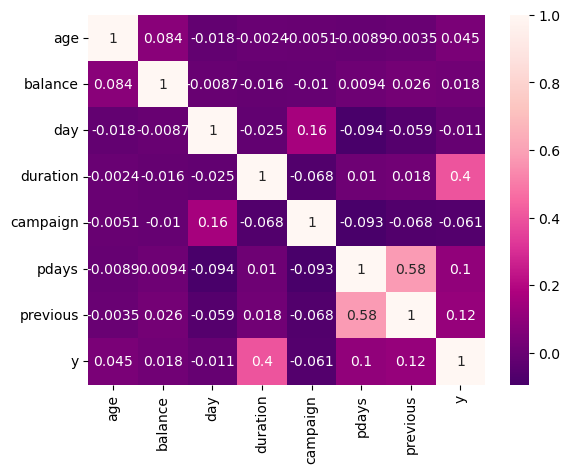

In [354]:
#Plotting heatmap for numeric features
mydf = bankDf.copy()
mydf['y'].replace({"yes":1, "no": 0}, inplace= True)
sns.heatmap(mydf.corr(numeric_only=True), annot=True, cmap='RdPu_r')

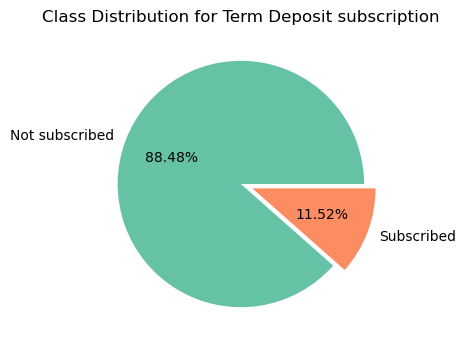

In [355]:
#Lets see if the classes are balanced
explode = [0, 0.1]
plt.figure(figsize=(4, 4))
plt.pie(bankDf["y"].value_counts(), explode=explode, labels=["Not subscribed", "Subscribed"], autopct='%.02f%%', colors=colorSet2) 
plt.title("Class Distribution for Term Deposit subscription")
plt.show()

#Classes are highly imbalanced. This may affect the ROC-AUC and F1-score

In [356]:
#plot all data for subscribed customers
subDf = bankDf[bankDf['y']=='yes']

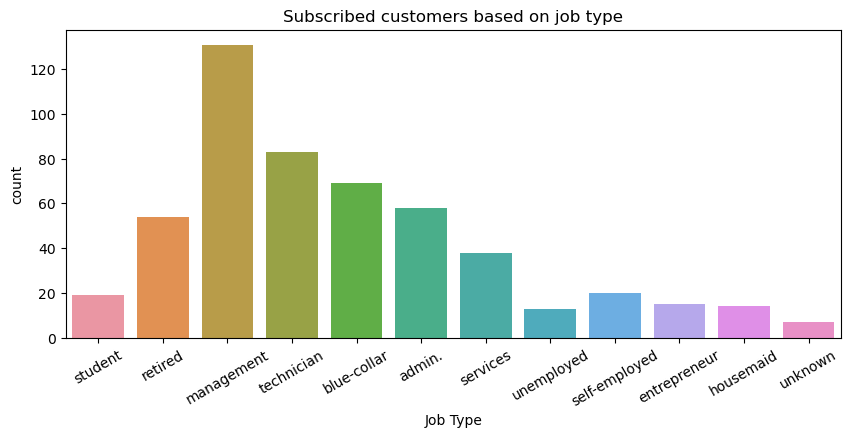

In [357]:
# Barplot of Subscribed customers based on job type
plt.figure(figsize=(10, 4))
sns.countplot(x='job', data=subDf)
plt.title("Subscribed customers based on job type")
plt.xlabel("Job Type")
plt.xticks(rotation=30)
plt.show()

#Management job customers are highly likely to subscribe along with technicians/blue-collar jobs

In [358]:
categorical_features = ['job', 'marital', 'education','contact', 'month', 'poutcome']

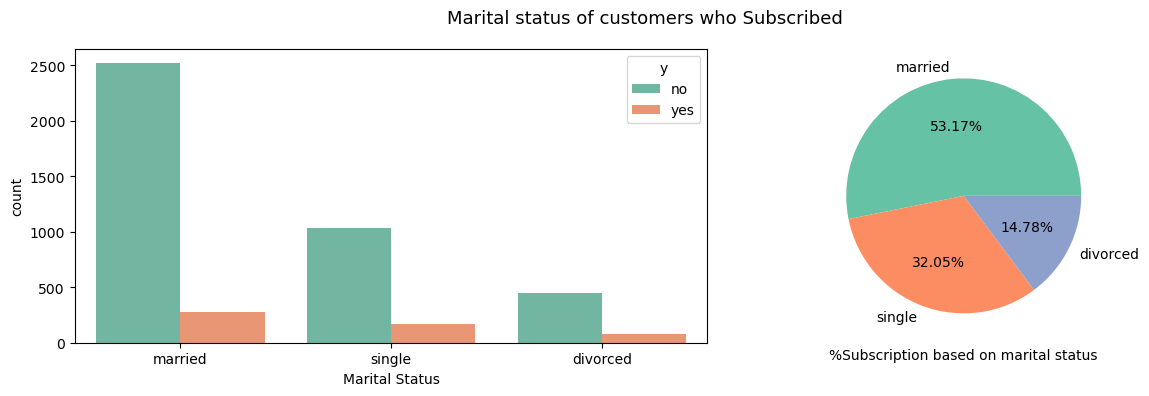

In [359]:
# Barplot and pie plot for marital status for customers subscribed
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))
fig.suptitle("Marital status of customers who Subscribed", fontsize = 13)
sns.countplot(x='marital', data=bankDf, hue='y', ax = ax1, palette="Set2")
ax1.set_xlabel('Marital Status')
valCounts = subDf['marital'].value_counts() 
plt.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2) 
ax2.set_xlabel('%Subscription based on marital status')
plt.tight_layout() 
plt.show()

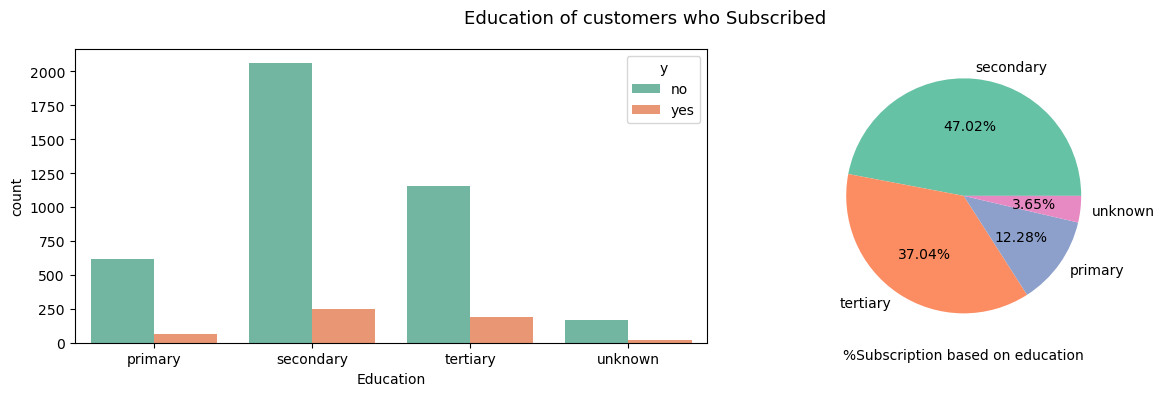

In [360]:
# Barplot and pie plot for education for customers subscribed
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))
fig.suptitle("Education of customers who Subscribed", fontsize = 13)
sns.countplot(x='education', data=bankDf, hue='y', ax = ax1, palette="Set2")
ax1.set_xlabel('Education')

valCounts = subDf['education'].value_counts() 
plt.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2) 
ax2.set_xlabel('%Subscription based on education')
plt.tight_layout() 
plt.show()

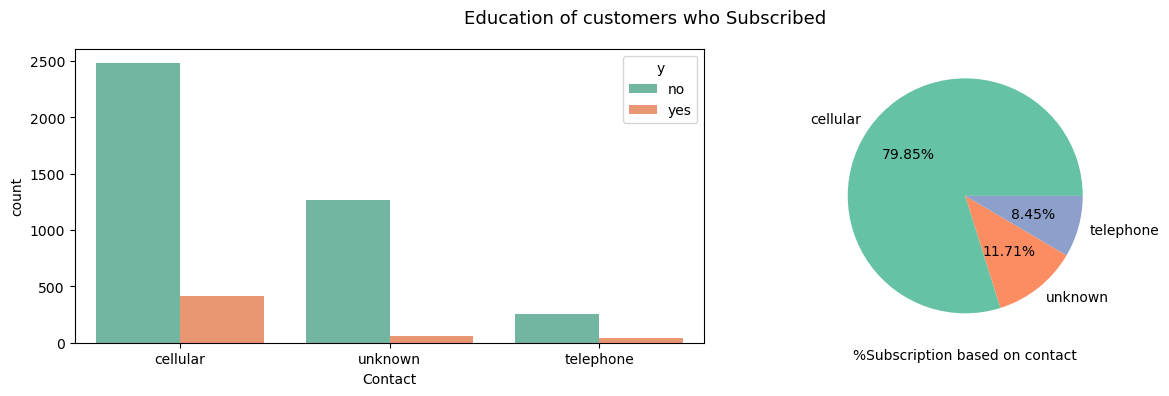

In [361]:
# Barplot and pie plot for contact for customers subscribed
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))
fig.suptitle("Education of customers who Subscribed", fontsize = 13)
sns.countplot(x='contact', data=bankDf, hue='y', ax = ax1, palette="Set2")
ax1.set_xlabel('Contact')

valCounts = subDf['contact'].value_counts() 
plt.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2) 
ax2.set_xlabel('%Subscription based on contact')
plt.tight_layout() 
plt.show()

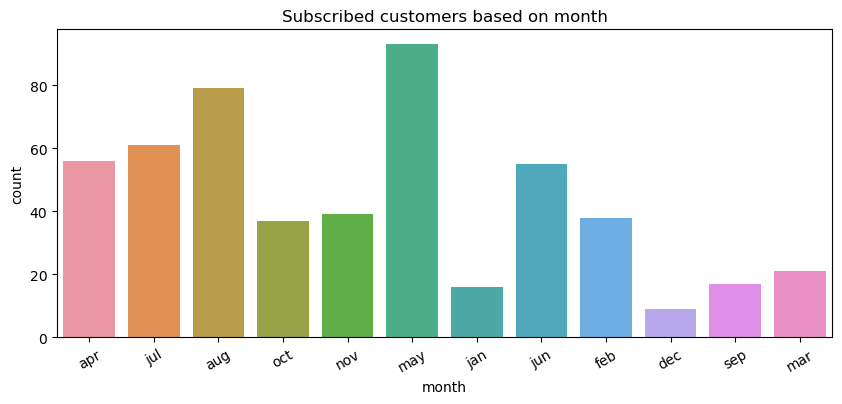

In [362]:
# Barplot of Subscribed customers based on month
plt.figure(figsize=(10, 4))
sns.countplot(x='month', data=subDf)
plt.title("Subscribed customers based on month")
plt.xticks(rotation=30)
plt.show()

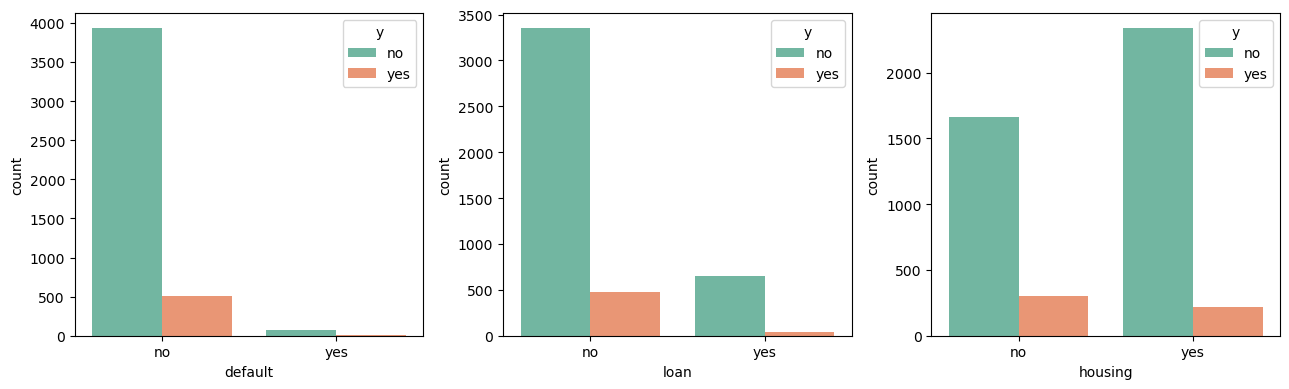

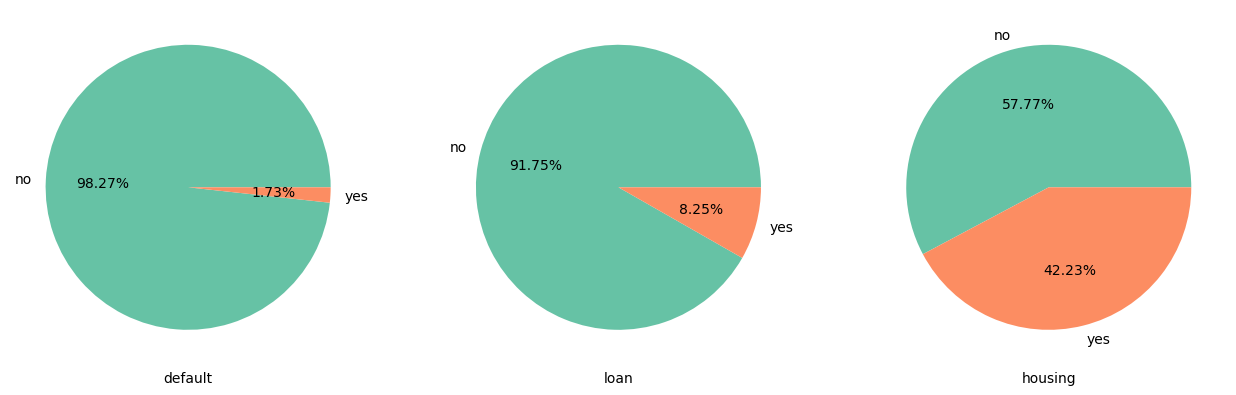

In [363]:
# Barplot plot for default, loan,housing for customers subscribed
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (13, 4))
sns.countplot(x='default', data=bankDf, hue='y', ax = ax1, palette="Set2")
sns.countplot(x='loan', data=bankDf, hue='y', ax = ax2, palette="Set2")
sns.countplot(x='housing', data=bankDf, hue='y', ax = ax3, palette="Set2")
plt.tight_layout() 
plt.show()

#pie plot for default, loan,housing  for customers subscribed
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (13, 4))
valCounts = subDf['default'].value_counts()
ax1.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2)
ax1.set_xlabel('default')
valCounts = subDf['loan'].value_counts() 
ax2.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2)
ax2.set_xlabel('loan')
valCounts = subDf['housing'].value_counts() 
ax3.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2)
ax3.set_xlabel('housing')
plt.tight_layout() 
plt.show()

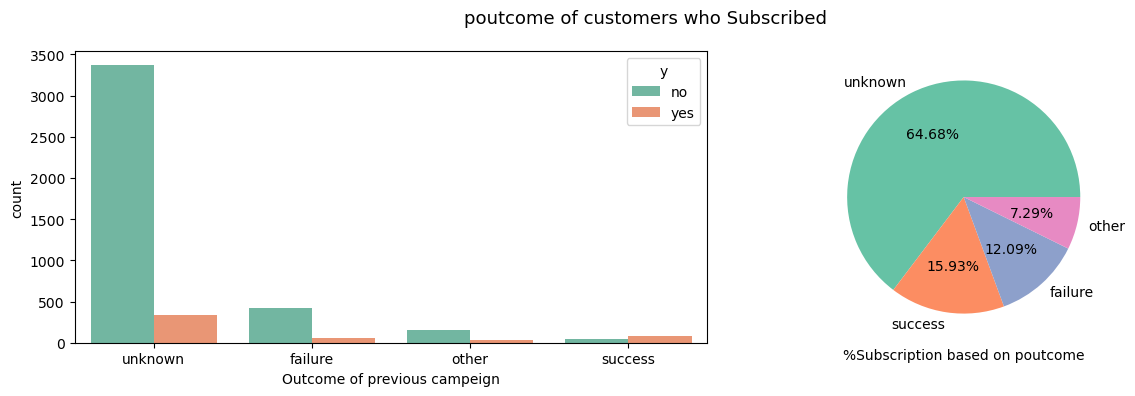

In [364]:
# Barplot and pie plot for poutcome for customers subscribed
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4))
fig.suptitle("poutcome of customers who Subscribed", fontsize = 13)
sns.countplot(x='poutcome', data=bankDf, hue='y', ax = ax1, palette="Set2")
ax1.set_xlabel('Outcome of previous campeign')
valCounts = subDf['poutcome'].value_counts() 
plt.pie(valCounts, labels=valCounts.index.tolist(), autopct='%.02f%%', colors=colorSet2) 
ax2.set_xlabel('%Subscription based on poutcome')
plt.tight_layout() 
plt.show()

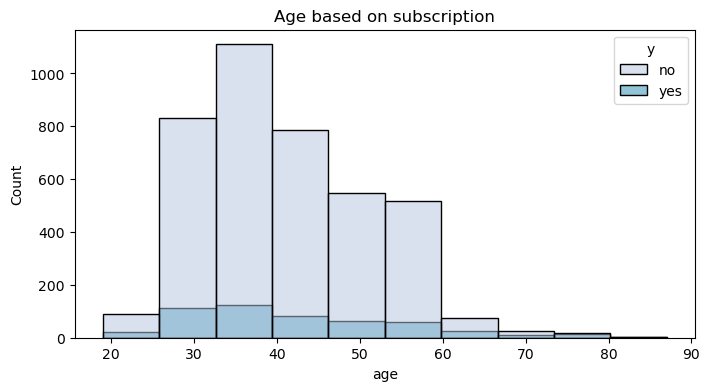

In [365]:
#Histograms of numeric features Age
plt.figure(figsize=(8, 4))
sns.histplot(x='age', data=bankDf, hue='y', bins=10, palette="PuBuGn")
plt.title("Age based on subscription")
plt.show()

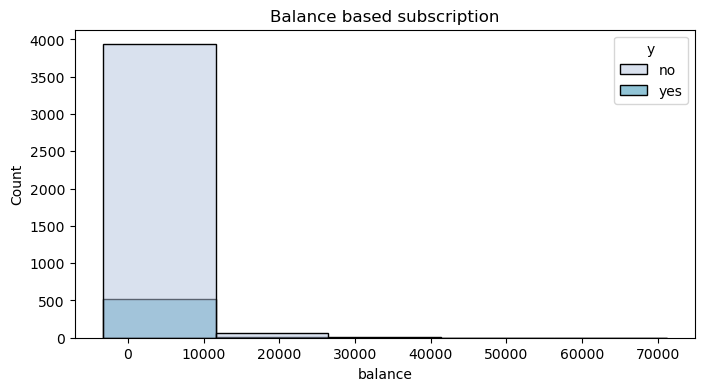

In [366]:
#Histogram of Balance distribution
plt.figure(figsize=(8, 4))
sns.histplot(x='balance', data=bankDf, hue='y', bins=5, palette="PuBuGn")
plt.title("Balance based subscription")
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [367]:
#Map binary columns
bankChurnDf = bankDf.copy()
columnsToMap = ['default', 'housing', 'loan', 'y']
for col in columnsToMap:
    bankChurnDf[col].replace({'no': 0, 'yes': 1}, inplace=True)

In [368]:
# Drop day column as it does not add value
bankChurnDf = bankChurnDf.drop(columns = ['day'], axis=1)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [369]:
#Encoder and preprocessor
categorical_features = ['job', 'marital', 'education','contact', 'month', 'poutcome']

numeric_features =['age', 'default', 'housing', 'loan', 
                   'campaign', 'pdays', 'previous','duration']

# Define preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [370]:
# Split the data into training and testing sets
X = bankChurnDf.drop(['y'], axis=1)
y = bankChurnDf["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [371]:
#common function to arun different models
def evaluate_model(model_pipe, params_grid, name):
    grid_search = GridSearchCV(model_pipe, params_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    start_time = time.time()
    #Fit the grid_search with training dataset
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = grid_search.best_estimator_
    print(f'Best model {best_model[1]}')
    
    #predict churn for the test dataset
    y_pred = best_model.predict(X_test)

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='RdPu')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    result_dict = pd.DataFrame({
        'Name'             : [name],
        'Accuracy'         : [accuracy_score(y_test, y_pred)],
        'Recall'           : [recall_score(y_test, y_pred)],
        'Precision'        : [precision_score(y_test, y_pred)],
        'F1 score'         : [f1_score(y_test, y_pred)],
        'ROC-AUC score'    : [roc_auc_score(y_test, y_pred)],
        'Average Fit Time' : [grid_search.cv_results_['mean_fit_time'].mean()],
    })
    perm_importance = permutation_importance(grid_search, X_test, y_test, n_repeats=30, random_state=42)
    feature_importance = pd.DataFrame({'feature': X_test.columns, 'importance': perm_importance.importances_mean})
    featureSorted = feature_importance.sort_values(by='importance', ascending=False)
    return (result_dict, featureSorted)

Best model LogisticRegression(C=0.1, max_iter=10000)


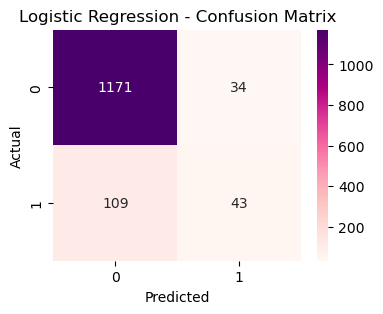

,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,Logistic Regression,0.89462,0.282895,0.558442,0.375546,0.627339,0.06849


In [372]:
# Create a pipeline with StandardScaler and LogisticRegression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ("logreg", LogisticRegression(max_iter=10000)), # LogisticRegression
])

# Define the parameter grid for grid search
param_grid_logreg = {'logreg__C': [0.01, 0.1, 1, 10, 100]}
#Evaluate  Logistic Regression and calculate performance
(logreg_df, logreg_perm) = evaluate_model(logreg_pipeline, param_grid_logreg, "Logistic Regression")
logreg_df

Best model KNeighborsClassifier(n_neighbors=9)


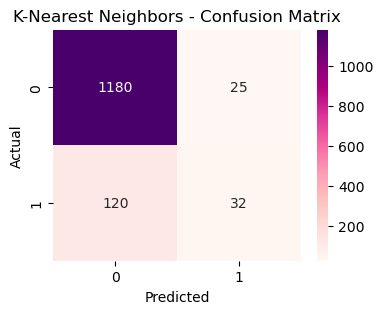

In [373]:
#Run K-Nearest Neighbors
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Scaling
    ("knn", KNeighborsClassifier()) # KNeighborsClassifier
])

param_grid_knn = {'knn__n_neighbors':[1, 3, 5, 7, 9]}
#Evaluate K-Nearest Neighbors and calculate performance
knn_df, knn_perm = evaluate_model(knn_pipeline, param_grid_knn, "K-Nearest Neighbors")

Best model DecisionTreeClassifier(max_depth=5)


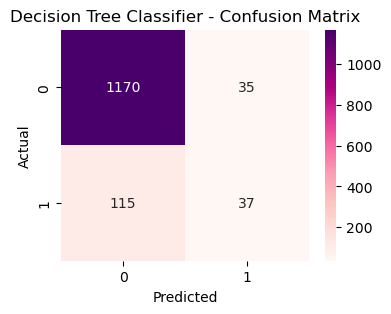

In [374]:
#Run Decision Tree Classifier"
dtc_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Scaling
    ("dtc", DecisionTreeClassifier()) # DecisionTreeClassifier
])
param_grid_dt = {'dtc__max_depth': [3, 5, 7, 10]}
#Evaluate Decision Tree Classifier and calculate performance
dtc_df, dtc_perm = evaluate_model(dtc_pipeline, param_grid_dt, "Decision Tree Classifier")

Best model SVC(C=0.1, kernel='linear', probability=True)


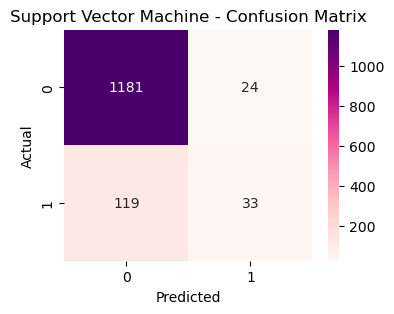

In [375]:
#Run Support Vector Machine
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Scaling
    ("svm", SVC(probability=True)) # Support Vector Machine
])
param_grid_svm = {'svm__C': [0.1, 1, 10], 
                  'svm__kernel': ['linear', 'rbf']}

#Evaluate Support Vector Machine and calculate performance
svm_df, svm_perm = evaluate_model(svm_pipeline, param_grid_svm, "Support Vector Machine")

In [376]:
#print("Model performance without SMOTE")
resultDf = pd.concat([logreg_df, knn_df, dtc_df, svm_df])
resultDf = resultDf.reset_index()
resultDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4 non-null      int64  
 1   Name              4 non-null      object 
 2   Accuracy          4 non-null      float64
 3   Recall            4 non-null      float64
 4   Precision         4 non-null      float64
 5   F1 score          4 non-null      float64
 6   ROC-AUC score     4 non-null      float64
 7   Average Fit Time  4 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 388.0+ bytes


In [377]:
print("Model performance without SMOTE")
# Highlight maximum values in each column of type float64
def highlight_max_float64(s):
    is_float = s.dtype == 'float64'
    return ['background-color: lightgreen' if is_float and v == s.max() else '' for v in s]

resultDf.style.apply(highlight_max_float64)

Model performance without SMOTE


,index,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,0,Logistic Regression,0.894620,0.282895,0.558442,0.375546,0.627339,0.068490
1,0,K-Nearest Neighbors,0.893147,0.210526,0.561404,0.306220,0.594890,0.035931
2,0,Decision Tree Classifier,0.889462,0.243421,0.513889,0.330357,0.607188,0.027409
3,0,Support Vector Machine,0.894620,0.217105,0.578947,0.315789,0.598594,1.608279


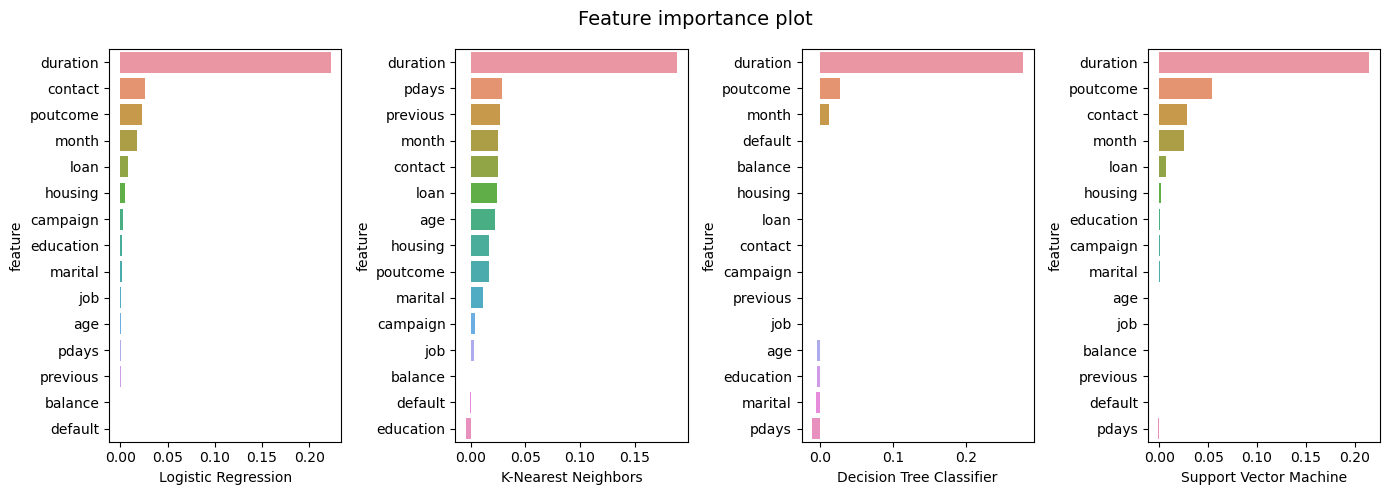

In [378]:
#Display all permutation importance 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 5))
fig.suptitle("Feature importance plot", fontsize = 14)
sns.barplot(logreg_perm, y= 'feature', x= 'importance', ax = ax1)
ax1.set_xlabel('Logistic Regression')

sns.barplot(knn_perm, y= 'feature', x= 'importance', ax = ax2)
ax2.set_xlabel('K-Nearest Neighbors')

sns.barplot(dtc_perm, y= 'feature', x= 'importance', ax = ax3)
ax3.set_xlabel('Decision Tree Classifier')

sns.barplot(svm_perm, y= 'feature', x= 'importance', ax = ax4)
ax4.set_xlabel('Support Vector Machine')

plt.tight_layout() 
plt.show()

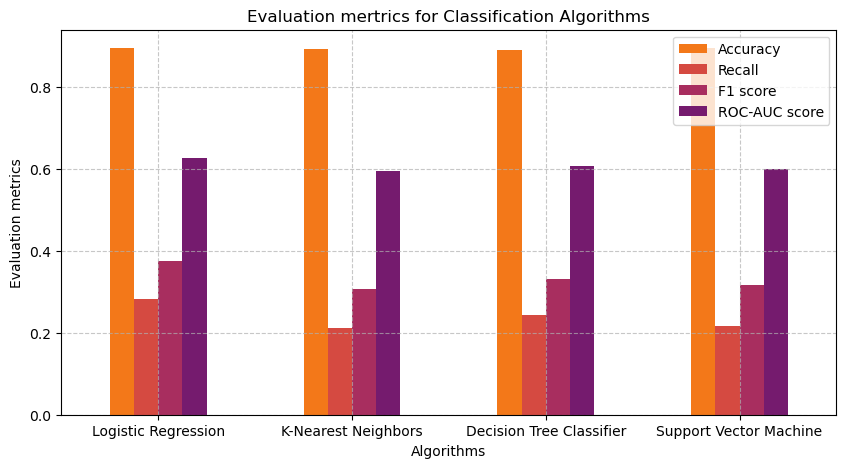

In [379]:
#Plot the Evaluation mertrics for Classification Algorithms
resultDf.plot(x="Name", y=["Accuracy", "Recall", "F1 score", "ROC-AUC score"],
        kind="bar", figsize=(10, 5), color=color)
plt.title("Evaluation mertrics for Classification Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("Evaluation metrics")
plt.xticks(rotation=0)
plt.grid(alpha=0.7,  linestyle='--')
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Based on above results its clear that the class imbalance has lead to a poor performance.
Though the accucary is high, The F1-score and ROC-AUC values are sub-optimal. This hamper the model's ability to clearly distinguish between a customer who will subscribe or not. 
To Enhance this we need to use Sampling to balance out the classes. Here we are using SMOTE (Synthetic minority over-sampling technique).

In [380]:
# Encode the categorical features and run SMOTE
encoded_df = pd.get_dummies(bankChurnDf, columns=categorical_features)

X = encoded_df.drop('y', axis=1)
y = encoded_df['y']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

Re-run all 4 models and analyze the performance.

Best model LogisticRegression(C=100, max_iter=10000)


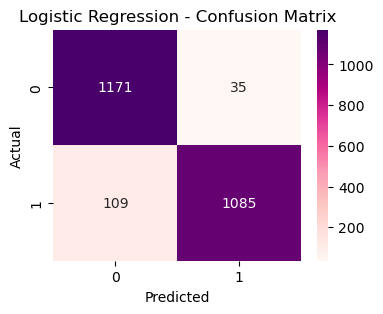

,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,Logistic Regression,0.94,0.90871,0.96875,0.93777,0.939844,0.086615


In [381]:
# Create a pipeline with StandardScaler and LogisticRegression
logreg_pipeline = Pipeline([
("scale", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=10000)), # LogisticRegression
])

# Define the parameter grid for grid search
param_grid_logreg = {'logreg__C': [0.01, 0.1, 1, 10, 100]}
#Evaluate  Logistic Regression and calculate performance
(logreg_df, logreg_perm) = evaluate_model(logreg_pipeline, param_grid_logreg, "Logistic Regression")
logreg_df

Best model KNeighborsClassifier(n_neighbors=9)


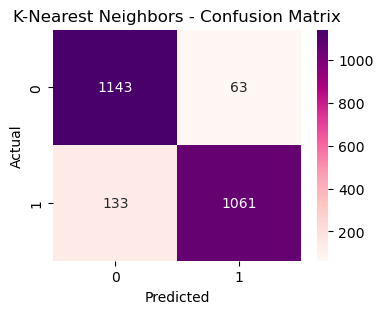

,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,K-Nearest Neighbors,0.918333,0.88861,0.94395,0.915444,0.918185,0.019329


In [382]:
#Run K-Nearest Neighbors
knn_pipeline = Pipeline([
("scale", StandardScaler()),  # Scaling
    ("knn", KNeighborsClassifier()) # KNeighborsClassifier
])

param_grid_knn = {'knn__n_neighbors':[1, 3, 5, 7, 9]}
#Evaluate K-Nearest Neighbors and calculate performance
knn_df, knn_perm = evaluate_model(knn_pipeline, param_grid_knn, "K-Nearest Neighbors")
knn_df

Best model DecisionTreeClassifier(max_depth=7)


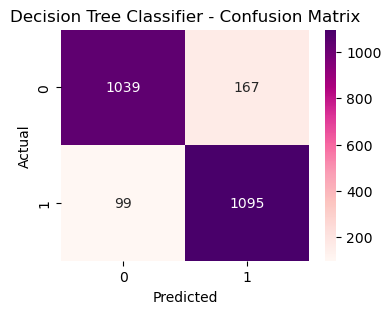

,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,Decision Tree Classifier,0.889167,0.917085,0.86767,0.891694,0.889306,0.039357


In [383]:
#Run Decision Tree Classifier"
dtc_pipeline = Pipeline([
("scale", StandardScaler()), # Scaling
    ("dtc", DecisionTreeClassifier()) # DecisionTreeClassifier
])
param_grid_dt = {'dtc__max_depth': [3, 5, 7, 10]}
#Evaluate Decision Tree Classifier and calculate performance
dtc_df, dtc_perm = evaluate_model(dtc_pipeline, param_grid_dt, "Decision Tree Classifier")
dtc_df

Best model SVC(C=1, kernel='linear', probability=True)


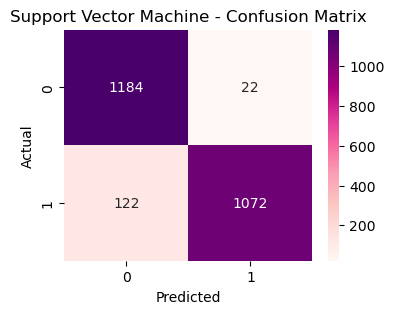

,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,Support Vector Machine,0.94,0.897822,0.97989,0.937063,0.93979,8.100839


In [384]:
#Run Support Vector Machine
svm_pipeline = Pipeline([
("scale", StandardScaler()), # Scaling
    ("svm", SVC(probability=True)) # Support Vector Machine
])
param_grid_svm = {'svm__C': [0.1, 1, 10], 
                  'svm__kernel': ['linear', 'rbf']}

#Evaluate Support Vector Machine and calculate performance
svm_df, svm_perm = evaluate_model(svm_pipeline, param_grid_svm, "Support Vector Machine")
svm_df

In [385]:
#Concat all learned DFs from models and display the results
print("                  Model Perfomance with SMOTE")
resultDf2 = pd.concat([logreg_df, knn_df, dtc_df, svm_df])
resultDf2 = resultDf2.reset_index()
resultDf2.info()

                  Model Perfomance with SMOTE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4 non-null      int64  
 1   Name              4 non-null      object 
 2   Accuracy          4 non-null      float64
 3   Recall            4 non-null      float64
 4   Precision         4 non-null      float64
 5   F1 score          4 non-null      float64
 6   ROC-AUC score     4 non-null      float64
 7   Average Fit Time  4 non-null      float64
dtypes: float64(6), int64(1), object(1)
memory usage: 388.0+ bytes


In [389]:
print("Model performance without SMOTE")
# Highlight maximum values in each column of type float64
def highlight_max_float64(s):
    is_float = s.dtype == 'float64'
    return ['background-color: lightgreen' if is_float and v == s.max() else '' for v in s]

resultDf.style.apply(highlight_max_float64)

Model performance without SMOTE


,index,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,0,Logistic Regression,0.894620,0.282895,0.558442,0.375546,0.627339,0.068490
1,0,K-Nearest Neighbors,0.893147,0.210526,0.561404,0.306220,0.594890,0.035931
2,0,Decision Tree Classifier,0.889462,0.243421,0.513889,0.330357,0.607188,0.027409
3,0,Support Vector Machine,0.894620,0.217105,0.578947,0.315789,0.598594,1.608279


In [388]:
print("Model performance with SMOTE")
# Highlight maximum values in each column of type float64
def highlight_max_float64(s):
    is_float = s.dtype == 'float64'
    return ['background-color: lightgreen' if is_float and v == s.max() else '' for v in s]

resultDf2.style.apply(highlight_max_float64)

Model performance without SMOTE
Model performance with SMOTE


,index,Name,Accuracy,Recall,Precision,F1 score,ROC-AUC score,Average Fit Time
0,0,Logistic Regression,0.940000,0.908710,0.968750,0.937770,0.939844,0.086615
1,0,K-Nearest Neighbors,0.918333,0.888610,0.943950,0.915444,0.918185,0.019329
2,0,Decision Tree Classifier,0.889167,0.917085,0.867670,0.891694,0.889306,0.039357
3,0,Support Vector Machine,0.940000,0.897822,0.979890,0.937063,0.939790,8.100839


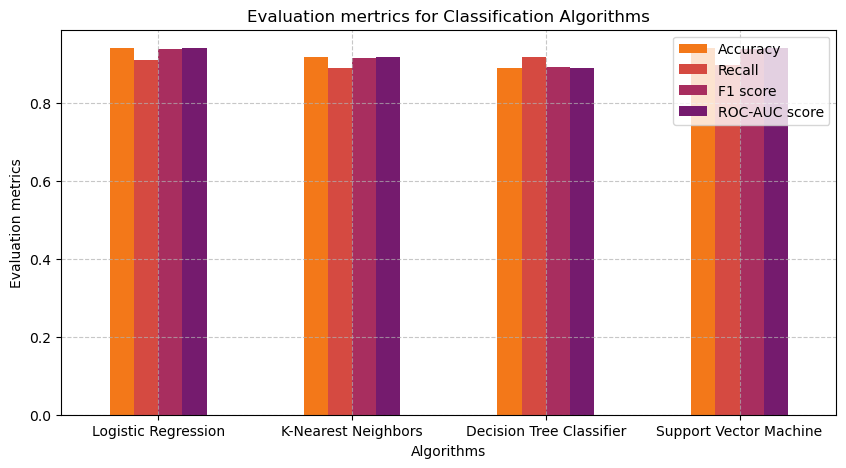

In [387]:
#Plot the Evaluation mertrics for Classification Algorithms
resultDf2.plot(x="Name", y=["Accuracy", "Recall", "F1 score", "ROC-AUC score"],
        kind="bar", figsize=(10, 5), color=color)
plt.title("Evaluation mertrics for Classification Algorithms")
plt.xlabel("Algorithms")
plt.ylabel("Evaluation metrics")
plt.xticks(rotation=0)
plt.grid(alpha=0.7,  linestyle='--')
plt.show()

Model performance and comparision
        -   Considering the F1-score and ROC-AUC, All 4 models performed well with very minor differences.
        -   Logistic Regression outperformed SVM in F1-score, ROC-AUC as well as mean fit time.
        -   SVM has the highest precision score and the worst fit time of 8 seconds
        -   Decision Tree Classifier has recall score and lowest on all other params
        -   K-Nearest Neighbors has the lowest fit time average scores ranging in 0.91

    Based on the comparison metrics and the requirements, User should choose Logistic regression or SVM for their classification. 
    However, if the dataset is higher and not much computational power available, then SVM's can lead to incorrect and incomplete results.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

    6.1 Overview
        European banks are currently looking to optimize the way customers are targeted directly and produce better subscription rates. They would
        need to identify the success attributes of the last campaign, ideal the demographic to focus, any seasonal parameter, and even the number of times
        a customer needs to be contacted to seal the deal. By analyzing the given dataset here are some insights into these factors and some suggestions for 
        further steps you can take to increase the success rate customer acquisition and optimize the campaign to save on valuable resources and money.

    6.2 Strategies to implement
        1.  Targeted Marketing Campaigns: Identify a demographic that is likely to subscribe and tailor marketing strategies around to increase conversion rates.
        2.  Invest in further data accumulation: Understand that since the conversion rate is only 11%, further data accumulation is needed. Apart from the features
            that we currently have to try to get customers' life events, risk appetite, and even their financial habits.
        3.  Customer Service: Build trust with customers by providing transparent information about the term deposit product, understand the concerns,
            provide incentives for subscribing to the term deposit. Provide excellent customer service for their issues and concerns. Follow up periodically.
        4.  Feedback/Complaints: Collect feedback/complaints from customers who have subscribed to a term deposit to understand their experience and improve future offerings.
        5.  Referral Programs: Advertise referral incentives to existing and new members for successful subscriptions.

    6.5 Summary
        By leveraging these insights and taking proactive steps to optimize your campaign strategies, you can enhance your competitiveness, 
        attract more customers, and maximize profitability in the banking sector along with improved customer satisfaction.